# Lab 8-1  Combining the Energy Balance and Mass Balance:  Snowmelt!
put together by Jessica Lundquist, with help from Eli Schwat and Danny Hogan

In [1]:
import os
import urllib
from urllib.error import URLError
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

#import metpy
#from metpy.units import units
#import pint_xarray

import matplotlib.pyplot as plt

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
from dateutil.relativedelta import relativedelta

In [3]:
pip install --upgrade xarray

  Using cached xarray-2023.8.0-py3-none-any.whl (1.0 MB)
  Using cached numpy-1.25.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
     |████████████████████████████████| 12.7 MB 6.6 MB/s            
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.4
    Uninstalling pandas-1.3.4:
      Successfully uninstalled pandas-1.3.4
  Attempting uninstall: packaging
    Found existing installation: packaging 21.2
    Uninstalling packaging-21.2:
      Successfully uninstalled packaging-21.2
  Attempting uninstall: xarray
    Found existing installation: xarray 0.20.1
    Uninstalling xarray-0.20.1:
      Successfully uninstalled xarray-0.20.1
ERROR: pip's dependency resolver does not curr

In [23]:
#!pip install sublimpy
#from sublimpy import utils, variables, tidy

ERROR: Could not find a version that satisfies the requirement sublimpy (from versions: none)
ERROR: No matching distribution found for sublimpy


ModuleNotFoundError: No module named 'sublimpy'

# Inputs

Below, you can see that we are pulling in a lot of data.  Turbulence data are the mean values (one variable) and variances (two variables) over 5-minute intervals at each height.  w represents winds in the vertical direction, and u and v represent winds in the horizontal.  tc is the sonic temperature, based in the speed of sound, and h2o is the water vapor concentration (or specific humidity).  Thus, we represent vertical sensible heat flux by 'w_tc__height_tower' and vertical latent heat flux by 'w_h2o_height_tower'

We are going to focus on the 3m and 10m fluxes for this lab.  Lab 7-1 downloads all of the data and does more turbulence-focused calculations.

We are also looking at the radiation data and snow pillow data, referring to Lab 5-1 and 2-2, respectively.

We also introduce the soil moisture and soil heat flux data for the first time.  

This is like the point in the symphony when suddenly all of the instruments are playing in harmony and the concert hall is filled with sound.

In [4]:
# Note, if you only need a few missing things, just run the next one in this list
# data is downloaded to this file path
sos_download_dir='sosnoqc'

# Specify start and end dates for the data. Specify the format that the dates are in.
start_date = '20221101'
end_date = '20230618'

DATE_FORMAT_STR = '%Y%m%d' # you shouldn't want to change this one

# Specify the variables you want to download. We are grabbing it ALL this time around.
VARIABLE_NAMES = [
    # Sonic Anemometer Data for 4 towers
    'tc_3m_uw',     'spd_3m_uw',     'dir_3m_uw',     'u_3m_uw',   'v_3m_uw',   'w_3m_uw',   'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    
        'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
    'tc_10m_uw',    'spd_10m_uw',    'dir_10m_uw',    'u_10m_uw',  'v_10m_uw',  'w_10m_uw',  'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   
        'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',

   'tc_3m_ue',     'spd_3m_ue',     'dir_3m_ue',     'u_3m_ue',   'v_3m_ue',   'w_3m_ue',   'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    
        'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
    'tc_10m_ue',    'spd_10m_ue',    'dir_10m_ue',    'u_10m_ue',  'v_10m_ue',  'w_10m_ue',  'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   
        'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',

       'tc_3m_d',      'spd_3m_d',     'dir_3m_d',     'u_3m_d',   'v_3m_d',   'w_3m_d',   'u_u__3m_d',    'v_v__3m_d',    'w_w__3m_d',    
        'u_w__3m_d',    'v_w__3m_d',  'u_tc__3m_d',  'v_tc__3m_d',   'u_h2o__3m_d',  'v_h2o__3m_d',   'w_tc__3m_d',   'w_h2o__3m_d',
    'tc_10m_d',     'spd_10m_d',    'dir_10m_d',    'u_10m_d',  'v_10m_d',  'w_10m_d',  'u_u__10m_d',   'v_v__10m_d',   'w_w__10m_d',   
        'u_w__10m_d',   'v_w__10m_d', 'u_tc__10m_d', 'v_tc__10m_d',  'u_h2o__10m_d', 'v_h2o__10m_d',  'w_tc__10m_d',  'w_h2o__10m_d',

    
     'tc_2m_c',  'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_u__2m_c',    'v_v__2m_c',    'w_w__2m_c',    
        'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'tc_5m_c',  'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_u__5m_c',    'v_v__5m_c',    'w_w__5m_c',    
        'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'tc_15m_c', 'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_u__15m_c',   'v_v__15m_c',   'w_w__15m_c',   
        'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'tc_20m_c', 'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_u__20m_c',   'v_v__20m_c',   'w_w__20m_c',   
        'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',
    
    
    # Temperature & Relative Humidity Array 
    'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Longwave Radiometer (tower D) - for measuring incoming and outgoing longwave radiation
    'Rpile_out_9m_d',
    'Tcase_out_9m_d',
    'Rpile_in_9m_d',
    
    # Upward and downward facing shortwave radiometers (tower D) - for measuring solar radiation!
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',
    
    # Radiometer on the UW tower
    'Rsw_in_uw',
    'Rsw_out_uw',
    'Rpile_in_uw',
    'Rpile_out_uw',
    'Tcase_uw',
    
    # Soil sensors, including soil moisture (Q) and heat flux (G)
    'Qsoil_d',
    'Gsoil_d',
    'Tsoil_0_6cm_d',
    'Tsoil_1_9cm_d',
    'Tsoil_3_1cm_d',
    'Tsoil_4_4cm_d',
    'Tsoil_8_1cm_d',
    'Tsoil_9_4cm_d',
    'Tsoil_10_6cm_d',
    'Tsoil_11_9cm_d',
    'Tsoil_18_1cm_d',
    'Tsoil_19_4cm_d',
    'Tsoil_20_6cm_d',
    'Tsoil_21_9cm_d',
    'Tsoil_28_1cm_d',
    'Tsoil_29_4cm_d',
    'Tsoil_30_6cm_d',
    'Tsoil_31_9cm_d',
    
    # Snow pillow sensors
    'SWE_p1_c',
    'SWE_p2_c',
    'SWE_p3_c',
    'SWE_p4_c',
]


In [3]:
# data is downloaded to this file path
sos_download_dir='sosnoqc'

# Specify start and end dates for the data. Specify the format that the dates are in.
start_date = '20221101'
end_date = '20230618'

DATE_FORMAT_STR = '%Y%m%d' # you shouldn't want to change this one

# Specify the variables you want to download. 
# in this case, I'm just trying to grab the center tower levels we missed before
VARIABLE_NAMES = [
    # Sonic Anemometer Data for central towers   
     'tc_2m_c',  'spd_2m_c',     'dir_2m_c',     'u_2m_c',   'v_2m_c',   'w_2m_c',   'u_u__2m_c',    'v_v__2m_c',    'w_w__2m_c',    
        'u_w__2m_c',    'v_w__2m_c',  'u_tc__2m_c',  'v_tc__2m_c',   'u_h2o__2m_c',  'v_h2o__2m_c',   'w_tc__2m_c',   'w_h2o__2m_c',
    'tc_3m_c',  'spd_3m_c',     'dir_3m_c',     'u_3m_c',   'v_3m_c',   'w_3m_c',   'u_u__3m_c',    'v_v__3m_c',    'w_w__3m_c',    
        'u_w__3m_c',    'v_w__3m_c',  'u_tc__3m_c',  'v_tc__3m_c',   'u_h2o__3m_c',  'v_h2o__3m_c',   'w_tc__3m_c',   'w_h2o__3m_c',
    'tc_5m_c',  'spd_5m_c',     'dir_5m_c',     'u_5m_c',   'v_5m_c',   'w_5m_c',   'u_u__5m_c',    'v_v__5m_c',    'w_w__5m_c',    
        'u_w__5m_c',    'v_w__5m_c',  'u_tc__5m_c',  'v_tc__5m_c',   'u_h2o__5m_c',  'v_h2o__5m_c',   'w_tc__5m_c',   'w_h2o__5m_c',
    'tc_10m_c', 'spd_10m_c',    'dir_10m_c',    'u_10m_c',  'v_10m_c',  'w_10m_c',  'u_u__10m_c',   'v_v__10m_c',   'w_w__10m_c',   
        'u_w__10m_c',   'v_w__10m_c', 'u_tc__10m_c', 'v_tc__10m_c',  'u_h2o__10m_c', 'v_h2o__10m_c',  'w_tc__10m_c',  'w_h2o__10m_c',
    'tc_15m_c', 'spd_15m_c',    'dir_15m_c',    'u_15m_c',  'v_15m_c',  'w_15m_c',  'u_u__15m_c',   'v_v__15m_c',   'w_w__15m_c',   
        'u_w__15m_c',   'v_w__15m_c', 'u_tc__15m_c', 'v_tc__15m_c',  'u_h2o__15m_c', 'v_h2o__15m_c',  'w_tc__15m_c',  'w_h2o__15m_c',
    'tc_20m_c', 'spd_20m_c',    'dir_20m_c',    'u_20m_c',  'v_20m_c',  'w_20m_c',  'u_u__20m_c',   'v_v__20m_c',   'w_w__20m_c',   
        'u_w__20m_c',   'v_w__20m_c', 'u_tc__20m_c', 'v_tc__20m_c',  'u_h2o__20m_c', 'v_h2o__20m_c',  'w_tc__20m_c',  'w_h2o__20m_c',
    
]


In [4]:
datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

# Define some functions we will use

Some of these you have seen before.

In [5]:
def download_sos_data(
    start_date,
    end_date,
    variable_names,
    local_download_dir = 'sosnoqc',
    cache = False,
    planar_fit = False
):
    """Download SoS datasets and perform a few preprocessing steps to clean up the data. 
    SoS datasets are NetCDF files from the ftp url provided by the Earth Observing Laboratory at NCAR.
    Data is the daily data reynolds averaged to 5 minutes. This function requires the caller to specify 
    the variables to be included in the output dataset because memory requirements are extensive if all 
    variables are included when merging datasets from many dates. 
    
    Specifically, this function:
    1. Downloads multiple netcdf files form the NCAR-EOL FTP server,
    2. Catches the URLERror thrown if the netcdf file for a specific date does not exist, and prints a 
        note that a failure occured,
    3. Merges the datasets into a single dataset, dealing with conflicts that arrise if some variables 
        are available in some datasets but not in others.
    4. Fills in missing timestamps so align with the 5 minute index that the datasets come in. 
        Timestamps may be missing in a single day's dataset if data-loss occured at the beginning 
        or end of a day.

    Args:
        start_date (str): first date to download data. in format '%Y%m%d', i.e. 20230101 for Jan 1, 2023/
        end_date (str): last date to download data. in format '%Y%m%d'.
        variable_names (list(str)): List of strings that represent NetCDF variable names to include in the
                combined dataset.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults to 'sosnoqc'; 
                this directory will be created if it does not already exist.
        cache (bool, optional): Whether or not to check the local_download_dir for the requested dataset. 
                If the file is already there, does not download it. Defaults to False.
        planar_fit (bool, optional): Whether or not to download data that has been planar fit by NCAR. These 
                datasets are not available for all dates. Defaults to False.
    Returns:
        xr.Dataset: Merged and cleaned dataset with specified data variables between specified dates.
    """
    datelist = pd.date_range(
        dt.datetime.strptime(start_date, '%Y%m%d'),
        dt.datetime.strptime(end_date, '%Y%m%d'),
        freq='d'
    ).strftime('%Y%m%d').tolist()

    # We make sure that we aren't accessing variables that don't exist in the datasets
    # This is necessary because some daily NetCDF files don't have all the expected variables
    # (for example because an instrument was down). In that case, we want to add that variable
    # to the dataset, filled with nans, which sosutils.merge_datasets_with_different_variables
    # handles for us
    datasets = []
    for date in datelist:
        try:
            ds = xr.open_dataset(download_sos_data_day(date, local_download_dir, cache=cache, planar_fit=planar_fit))
        # Some dates are missing
        except URLError:
            print(f"failed on {date}, skipping")
        ds_new = ds[set(ds.data_vars).intersection(variable_names)]
        datasets.append(ds_new)
        
    sos_ds = merge_datasets_with_different_variables(datasets, dim='time')
    sos_ds = fill_missing_timestamps(sos_ds)
    return sos_ds

def merge_datasets_with_different_variables(ds_list, dim='time'):
    """Take a list of datasets and merge them using xr.merge. First check that the two datasets
    have the same data vars. If they do not, missing data vars in each dataset are added with nan values
    so that the two datasets have the same set of data vars. NOTE: This gets slow with lots of datasets

    Args:
        ds_list (list(xr.Dataset)): list of xr.Dataset objects to merge.
        dim (string): dimension to merge datasets on. You probably want the default. Defaults to 'time'.
    Returns:
        xr.Dataset: Merged dataset.
    """
    def _merge_datasets_with_different_variables(ds1, ds2, dim):
        vars1 = set(ds1.data_vars)
        vars2 = set(ds2.data_vars)
        in1_notin2 = vars1.difference(vars2)
        in2_notin1 = vars2.difference(vars1)
        # add vars with NaN values to ds1
        for v in in2_notin1:
            ds1[v] = xr.DataArray(coords=ds1.coords, dims=ds1.dims)
        # add vars with NaN values to ds2
        for v in in1_notin2:
            ds2[v] = xr.DataArray(coords=ds2.coords, dims=ds2.dims)
        return xr.concat([ds1, ds2], dim=dim)

    new_ds = ds_list.pop(0)
    while ds_list:
        new_ds = _merge_datasets_with_different_variables(
            new_ds,
            ds_list.pop(0),
            dim=dim
        )
    return new_ds

def modify_df_timezone(df, source_tz, target_tz, time_col='time'):
    """Modify the timezone of a dataframe. The time data should NOT be an index of the provided 
        dataframe, there must be a column (time_col) with time data.

    Args:
        df (pd.DataFrame): _description_
        source_tz (_type_): A pytz timezone object specifying the timezone the data is already in. 
                For example, `pytz.UTC`.
        target_tz (_type_): A pytz timezone object specifying the timezone the data is to be 
                converted to. For example, `pytz.timezone('US/Mountain')`.
        time_col (str, optional): The dataframe column name that contains the time data. Defaults 
                to 'time'.

    Returns:
        pd.DataFrame: Dataframe with the time_col object overwritten with the modified timestamps.
    """
    df = df.copy()
    df[time_col] = df[time_col].dt.tz_localize(source_tz).dt.tz_convert(target_tz).dt.tz_localize(None)
    return df

def modify_xarray_timezone(ds, source_tz, target_tz):
    """Modify the timezone of an xr.Dataset. The dataset should have a coordinate and dimension 'time'.
    The returned xr.Dataset object will have the original 'time' coordinate/dimension overwritten.

    Args:
        ds (xr.Dataset): xarray Dataset object to have its time coordinate/dimension converted.
        source_tz (_type_): A pytz timezone object specifying the timezone the data is already in. 
                For example, `pytz.UTC`.
        target_tz (_type_): A pytz timezone object specifying the timezone the data is to be 
                converted to. For example, `pytz.timezone('US/Mountain')`.

    Returns:
        xr.Dataset: xarray Dataset with the time coordinate/dimension overwritten with the modified 
                timestamps.
    """
    ds = ds.copy()
    time_utc = ds['time'].to_index().tz_localize(source_tz)
    tz_corrected = time_utc.tz_convert(target_tz).tz_localize(None)
    local_da=xr.DataArray.from_series(tz_corrected)
    ds.coords.update({f'time ({target_tz})': tz_corrected})
    ds.coords.update({f'time ({source_tz})': ds['time'].to_index()})
    ds = ds.assign_coords({
        'time': ds[f'time ({target_tz})'].values
    })
    return ds

def fill_missing_timestamps(ds):
    """Fills in missing timestamps in an xr.Dataset for all data variables with NaN values. This is
    particularly useful when multiple daily NetCDF files have been merged together. SoS NetCDF files 
    generally have data every 5 minutes. If data is missing from the beginning or end of the day,
    there may be missing timestamps (e.g. if the power was out at the study site between 12am and 2am
    on a day, the first timestamp in the dataset will be 02:02:30). This can be confusing when we want 
    to combine datasets from different days. This function fills in all missing timestamps between the 
    first timestamp and the last timestamp in the provided xr.Dataset. It makes sure there is one 
    timestamp every 5 minutes. 

    Args:
        ds (xr.Dataset): Dataset to be filled. 
    """
    def date_range(start_date, end_date, increment, period):
        result = []
        nxt = start_date
        delta = relativedelta(**{period:increment})
        while nxt <= end_date:
            result.append(nxt)
            nxt += delta

        return result
    dt_list = date_range(pd.to_datetime(ds.time.values[0]), pd.to_datetime(ds.time.values[-1]), 5, 'minutes')
    ds = ds.drop_duplicates(dim='time').reindex(time=dt_list)

    return ds

In [6]:
def download_sos_data_day(date = '20221101', local_download_dir = 'sosnoqc', cache=False,  planar_fit = False):
    """Download a netcdf file from the ftp url provided by the Earth Observing Laboratory at NCAR.
    Data is the daily data reynolds averaged to 5 minutes.

    Args:
        date (str, optional): Date to download data. in format '%Y%m%d', i.e. 20230101 for Jan 1, 2023. Defaults 
                to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults to 'sosnoqc'; 
                this directory will be created if it does not already exist.
        cache (bool, optional): Whether or not to check the local_download_dir for the requested dataset. 
                If the file is already there, does not download it. Defaults to False.
        planar_fit (bool, optional): Whether or not to download data that has been planar fit by NCAR. These 
                datasets are not available for all dates. Defaults to False.

    Returns:
        str: file path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    if planar_fit:
        path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo_tiltcor/'
    else:
        path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    
    if planar_fit:
        file_example =  f'isfs_sos_tiltcor_{date}.nc'

    else:
        file_example = f'isfs_{date}.nc'

    os.makedirs(local_download_dir, exist_ok=True)

    full_file_path = os.path.join('ftp://', base_url, path, file_example)
    if planar_fit:
        download_file_path = os.path.join(local_download_dir, 'planar_fit', file_example)
    else:
        download_file_path = os.path.join(local_download_dir, file_example)
    

    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )

    return download_file_path


In [7]:
# Specify start and end dates for the data. Specify the format that the dates are in.
start_date = '20221101'
end_date = '20230618'

sos_ds = download_sos_data(
    start_date,
    end_date,
    variable_names=VARIABLE_NAMES,
    local_download_dir = 'sosnoqc',
    cache = True,
    planar_fit = False # allows downloading of the planar-fitted data      
)

Caching...skipping download for 20221101
Caching...skipping download for 20221102
Caching...skipping download for 20221103
Caching...skipping download for 20221104
Caching...skipping download for 20221105
Caching...skipping download for 20221106
Caching...skipping download for 20221107
Caching...skipping download for 20221108
Caching...skipping download for 20221109
Caching...skipping download for 20221110
Caching...skipping download for 20221111
Caching...skipping download for 20221112
Caching...skipping download for 20221113
Caching...skipping download for 20221114
Caching...skipping download for 20221115
Caching...skipping download for 20221116
Caching...skipping download for 20221117
Caching...skipping download for 20221118
Caching...skipping download for 20221119
Caching...skipping download for 20221120
Caching...skipping download for 20221121
Caching...skipping download for 20221122
Caching...skipping download for 20221123
Caching...skipping download for 20221124
Caching...skippi

In [8]:


def apogee2temp(ds,tower):
    # hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = ds[f"IDir_{tower}"]
    sns = [136, 137, 138, 139, 140]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
    # unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861, 58756.588][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285, 287.12487][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932, 2.11822][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453, -214.5312][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657, -0.59308][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234, 0.10936][im]* 1e5
    # read data
    Vtherm = ds[f"Vtherm_{tower}"]
    Vpile = ds[f"Vpile_{tower}"]*1000
    # calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
    # finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25 - 273.15
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    # TTc = TTc * units('celsius')
    return TTc


Note for spring data, there was major machine room maintenance at NCAR on 22 April, which resulted in us missing data on 22 April and 23 April.  This should be backed up on a thumb drive somewhere, but personally, I have not yet tracked down those days, so be aware when downloading data.

Before plotting, we resample the SoS dataset by finding the hourly mean. We don't need the high-rate (5 minute) data to look at season long changes. Also, the snow pillow dataset has lots of nans so resampling makes the plot look better. The precipitaton dataset is already daily, so we don't need to resample it.

In [9]:
sos_dataset_60min = sos_ds.resample(time="60Min").mean()

sos_dataset_60min.to_netcdf("sos_SWE_T_P.nc")Now we plot the data. Note that SWE_p1_c, SWE_p2_c, SWE_p3_c, SWE_p24_ corresponse to the snow pillows beneath towers UW, UE, C, D, respectively.

We plot this in conjunction with the snow temperature, the soil temperature, and the soil moisture, to see if we can detect the onset of melt.

In [10]:
# The below code writes our 60 minute data out to netcdf.  You can use this for the lab below if 
# we're having downloading issues.  Just uncomment the line you want, if you want any of them.
# to print the dataset:

sos_dataset_60min.to_netcdf("sos_EB_01Nov2022to18June2023_centerfluxesonly.nc")

# to load the dataset:

# sos_dataset_60min=xr.open_dataset("sos_EB_1to21April2023.nc")

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(10,20), sharex=True)
sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_60min['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')

#sos_dataset_60min['Tsnow_0_4m_d'].plot(ax=axes[1], label='T at 0.4 m')
sos_dataset_60min['Tsnow_0_5m_d'].plot(ax=axes[1], label='T at 0.5 m')
sos_dataset_60min['Tsnow_0_6m_d'].plot(ax=axes[1], label='T at 0.6 m')
sos_dataset_60min['Tsnow_0_7m_d'].plot(ax=axes[1], label='T at 0.7 m')
sos_dataset_60min['Tsnow_0_8m_d'].plot(ax=axes[1], label='T at 0.8 m')
sos_dataset_60min['Tsnow_0_9m_d'].plot(ax=axes[1], label='T at 0.9 m')
sos_dataset_60min['Tsnow_1_0m_d'].plot(ax=axes[1], label='T at 1.0 m')
sos_dataset_60min['Tsnow_1_1m_d'].plot(ax=axes[1], label='T at 1.1 m')
sos_dataset_60min['Tsnow_1_2m_d'].plot(ax=axes[1], label='T at 1.2 m')
sos_dataset_60min['Tsnow_1_3m_d'].plot(ax=axes[1], label='T at 1.3 m')
sos_dataset_60min['Tsnow_1_4m_d'].plot(ax=axes[1], label='T at 1.4 m')
sos_dataset_60min['Tsnow_1_5m_d'].plot(ax=axes[1], label='T at 1.5 m')

sos_dataset_60min['Tsoil_0_6cm_d'].plot(ax=axes[2], label='Tsoil at 0.6 cm')
#sos_dataset_60min['Tsoil_1_9cm_d'].plot(ax=axes[2], label='Tsoil at 1.9 cm')
#sos_dataset_60min['Tsoil_3_1cm_d'].plot(ax=axes[2], label='Tsoil at 3.1 cm')
#sos_dataset_60min['Tsoil_4_4cm_d'].plot(ax=axes[2], label='Tsoil at 4.4 cm')
sos_dataset_60min['Tsoil_8_1cm_d'].plot(ax=axes[2], label='Tsoil at 8.1 cm')
#sos_dataset_60min['Tsoil_9_4cm_d'].plot(ax=axes[2], label='Tsoil at 9.4 cm')
#sos_dataset_60min['Tsoil_10_6cm_d'].plot(ax=axes[2], label='Tsoil at 10.6 cm')
#sos_dataset_60min['Tsoil_11_9cm_d'].plot(ax=axes[2], label='Tsoil at 11.9 cm')
sos_dataset_60min['Tsoil_18_1cm_d'].plot(ax=axes[2], label='Tsoil at 18.1 cm')
#sos_dataset_60min['Tsoil_19_4cm_d'].plot(ax=axes[2], label='Tsoil at 19.4 cm')
#sos_dataset_60min['Tsoil_20_6cm_d'].plot(ax=axes[2], label='Tsoil at 20.6 cm')
#sos_dataset_60min['Tsoil_21_9cm_d'].plot(ax=axes[2], label='Tsoil at 21.9 cm')
sos_dataset_60min['Tsoil_28_1cm_d'].plot(ax=axes[2], label='Tsoil at 28.1 cm')
#sos_dataset_60min['Tsoil_29_4cm_d'].plot(ax=axes[2], label='Tsoil at 29.4 cm')
#sos_dataset_60min['Tsoil_30_6cm_d'].plot(ax=axes[2], label='Tsoil at 30.6 cm')
#sos_dataset_60min['Tsoil_31_9cm_d'].plot(ax=axes[2], label='Tsoil at 31.9 cm')

sos_dataset_60min['Qsoil_d'].plot(ax=axes[3], label='soil moisture')

sos_dataset_60min['Gsoil_d'].plot(ax=axes[4], label='soil heat flux')

sos_dataset_60min['T_2m_c'].plot(ax=axes[5])

axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
axes[3].set_xlabel("")
axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[4].legend()
axes[0].set_ylabel("Snow pillow,\nSnow Water Equivalent [mm]")
#axes[0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))
plt.show()

### Melt exited our snowpack on 10 April!
These are very exciting results (okay, at least Jessica is excited).  From the graph above, we can see that in early April, air temperatures stated going above 0 $^\circ$C during the day.  At this point in time, internal snowpack temperatures were mostly below 0 $^\circ$C, but they started warming.  A cold snowfall event around 5 April resulted in the snowpack cooling again, but then everything warmed again on 8 April.  By 10 April we see some crazy movement of water in the snow (at pillows 1 and 4), we see all snowpack thermistors warming to 0 $^\circ$C, and we see soil moisture jump up, more than doubling, at the same time the shallow soil temperatures rise. 

# Let's calculate some new variables and assess the total energy balance that led to these shifts.

We will do this on our 60 minute dataset, because we have a lot of variables.

## Calculate longwave radiation and surface temperatures

For calculating the temperature from the downward-facing, longwave radiometer, see EOL's methodology (https://www.eol.ucar.edu/content/calculation-long-wave-radiation)
$$
R_{lw} = R_{pile} + SB * T_{case}^4
$$
And the Steven-Boltzman law
$$
T_{surface} = \Big( \frac {R_{lw}}{ \epsilon \sigma } \Big)^\frac{1}{4}
$$

In [30]:
#SIGMA = 5.67e-8 # Stephan-Boltzmann Constant
#sos_ds = sos_ds.assign(LWout = (sos_ds.Rpile_out_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA),
#              LWin = (sos_ds.Rpile_in_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA))
# below is Eli's code and above is Danny's code -- At this point, I think we only need the below but saving the above just in case.

SB = 5.67e-08 # steven boltzman constant, W/m^2/degK^4
SNOW_EMMISIVITY = 0.98

sos_dataset_60min['LWin'] = (sos_dataset_60min['Rpile_in_9m_d'] + SB * (sos_dataset_60min['Tcase_out_9m_d']+273.15)**4)
sos_dataset_60min['LWout'] = (sos_dataset_60min['Rpile_out_9m_d'] + SB * (sos_dataset_60min['Tcase_out_9m_d']+273.15)**4)

sos_dataset_60min['Tsurf_rad_d'] = ((sos_dataset_60min['Rpile_out_9m_d'] + SB * (sos_dataset_60min['Tcase_out_9m_d']+273.15)**4)/(SNOW_EMMISIVITY*SB))**(1/4) - 273.15

# The above is for the 9 meter radiometer, which is the expensive one.  The below is for the uw radiometer, which is the less expensive "extra" one but also didn't break in April
sos_dataset_60min['LWin_uw'] = (sos_dataset_60min['Rpile_in_uw'] + SB * (sos_dataset_60min['Tcase_uw']+273.15)**4)
sos_dataset_60min['LWout_uw'] = (sos_dataset_60min['Rpile_out_uw'] + SB * (sos_dataset_60min['Tcase_uw']+273.15)**4)

sos_dataset_60min['Tsurf_rad_uw'] = ((sos_dataset_60min['Rpile_out_uw'] + SB * (sos_dataset_60min['Tcase_uw']+273.15)**4)/(SNOW_EMMISIVITY*SB))**(1/4) - 273.15

#Note that the uw radiometer also has 'Rsw_in_uw' and 'Rsw_out_uw' for shortwave, but these do not need extra processing

# Surface Temperature
# calculate from apogees
sos_dataset_60min['Tsurf_c'] = (['time'], apogee2temp(sos_dataset_60min, 'c').values)
sos_dataset_60min['Tsurf_d'] = (['time'], apogee2temp(sos_dataset_60min, 'd').values)
sos_dataset_60min['Tsurf_ue'] = (['time'], apogee2temp(sos_dataset_60min, 'ue').values)
sos_dataset_60min['Tsurf_uw'] = (['time'], apogee2temp(sos_dataset_60min, 'uw').values)

/opt/conda/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/opt/conda/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/opt/conda/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/opt/conda/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [31]:
# And calculate the density of air
Ra = 286.9
# above is specific gas constant for dry air in J/kg/K
sos_dataset_60min['ro'] = 100*sos_dataset_60min['P_10m_c']/(Ra * (sos_dataset_60min['T_10m_c']+273.15))

## Calculate the total energy balance each hour

The total energy balance at the snow suface is

$$
c_p^{SS} \frac{\delta T_{SS}}{\delta t} + \lambda \frac{\delta T_{S}}{\delta z} + E_{melt} = LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH + G 
$$

where the left hand side represents changes to the snowpack, through warming the surface temperature $c_p^{SS} \frac{\delta T_{SS}}{\delta t}$, conducting heat into lower layers of the snowpack $\lambda \frac{\delta T_{S}}{\delta z}$, or melting the snow $E_{melt}$.  

This is balanced by the heat exchange at the surface $LW_{in} - LW_{out} + SW_{in} - SW_{out} - LH - SH$ and the ground heat flux $G$.  

We need to be very careful with the signs and units of all of these terms, as we will see below.

## Calculate components and sums of surface fluxes

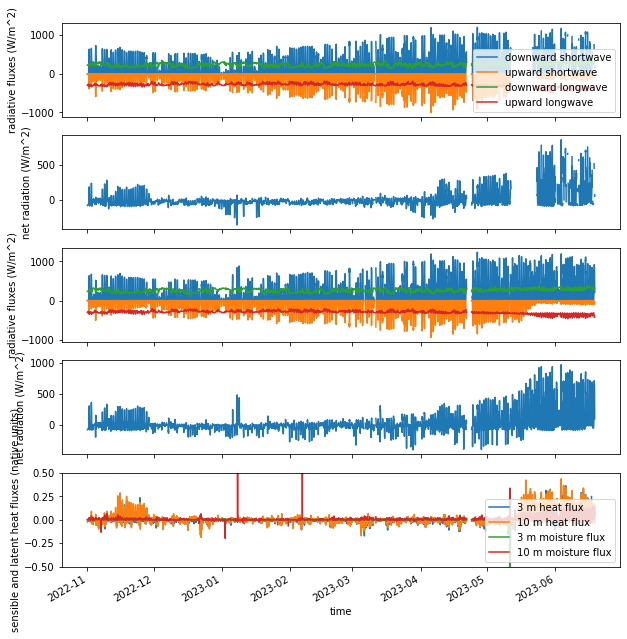

In [34]:
# import matplotlib.pyplot as plt

fig, axes = plt.subplots(5,1, figsize=(10,10), sharex=True)

sos_dataset_60min['Rsw_in_9m_d'].plot(ax=axes[0], label='downward shortwave')
(-1 * sos_dataset_60min['Rsw_out_9m_d']).plot(ax=axes[0], label='upward shortwave')
sos_dataset_60min['LWin'].plot(ax=axes[0], label='downward longwave')
(-1 * sos_dataset_60min['LWout']).plot(ax=axes[0], label='upward longwave')

(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']).plot(ax=axes[1], label='net rad')

# And now we fill in with the uw radiometer because the downwind tower one broke in May
sos_dataset_60min['Rsw_in_uw'].plot(ax=axes[2], label='downward shortwave')
(-1 * sos_dataset_60min['Rsw_out_uw']).plot(ax=axes[2], label='upward shortwave')
sos_dataset_60min['LWin_uw'].plot(ax=axes[2], label='downward longwave')
(-1 * sos_dataset_60min['LWout_uw']).plot(ax=axes[2], label='upward longwave')

(sos_dataset_60min['Rsw_in_uw'] + sos_dataset_60min['LWin_uw'] - sos_dataset_60min['Rsw_out_uw'] - sos_dataset_60min['LWout_uw']).plot(ax=axes[3], label='net rad')


# then, let's look at the sensible heat flux at two heights
sos_dataset_60min['w_tc__3m_c'].plot(ax=axes[4], label='3 m heat flux')
sos_dataset_60min['w_tc__10m_c'].plot(ax=axes[4], label='10 m heat flux')

# and let's look at the latent heat flux at two heights
sos_dataset_60min['w_h2o__3m_c'].plot(ax=axes[4], label='3 m moisture flux')
sos_dataset_60min['w_h2o__10m_c'].plot(ax=axes[4], label='10 m moisture flux')


axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].set_ylabel("radiative fluxes (W/m^2)")
axes[1].set_ylabel("net radiation (W/m^2)")

axes[2].set_xlabel("")
axes[3].set_xlabel("")
axes[2].set_ylabel("radiative fluxes (W/m^2)")
axes[3].set_ylabel("net radiation (W/m^2)")

axes[4].legend()
axes[4].set_ylabel("sensible and latent heat fluxes (native units)")
#axes[3].set_ylabel("Richardson Number")
axes[4].set_ylim(-0.5, 0.5)

plt.show()

### What do you notice in the plot above?  

The refelcted radiation looks less starting about 8 April.  This makes a big difference in the net radiation, particularly during the day     

It's also important to consider whether we have continuous snow cover and/or dust on snow during the period we chose.  You can see pictures [here](https://archive.eol.ucar.edu/docs/isf/projects/SOS/isfs/qcdata/images/20230408/index.html) -- photos show snowfall on 4 April but with dust appearing by 6 April and quite apparent (dark) on 8 April.  Note that you can click on "previous day" or "next day" on the website to see more photos.  Teaser, the night of 29 March had a laser light show all night from the lidar scanners... 

We see that the hourly average net radiation has some spikes around sunrise that would indicate that something odd is happening early in the morning.  This warrants further investigation.

We also see that, in general the 3 m and 10 m fluxes match, but sometimes the sensible heat flux at 3 m and 10 m is in different directions.  That also warrants further investigation.  Also, the direction of heat flux and moisture flux is typically opposite.  

To combine the net effect of moisture and heat flux on the energy balance of the snow, we need to pay particular attention to the direction and units of these measurements and then combine them.

### Net Turbulent Flux

First, the measurements define up as positive, so a movement of heat and moisture away from the snow is positive.  As we observed in Lab 7, Sensible heat flux is measured in K m/s and Latent heat flux is measured in g/m$^3$ m/s.  For these to comparable to the Radiative heat flux, we need to convert to W/m$^2$ at the snow surface.

The sensible heat flux is in air, and so the heat is carried by the air, so we multiply by the specific heat of air and the density of air to convert to W/m$^2$.

The latent heat flux is in mass flux and so needs to be converted to energy flux by multiplying by the latent heat of sublimation, 2835 J g$^{-1}$.  And if you are concerned that the snow first melted and then evaporated, don't worry, the latent heat of melt plus the latent heat of evaporation equals the latent heat of sublimation, so the net energy effect is the same.

**Now consider direction.**  A positive sensible heat flux moves heat away from the snow and so cools the snow.  A positie latent heat flux moves moisture away from the snow, which took energy to vaporize, and so cools the snow.  Therefore, we take the negative of the recorded values to compare directly with our radiative fluxes for a sum of fluxes towards the snow surface.

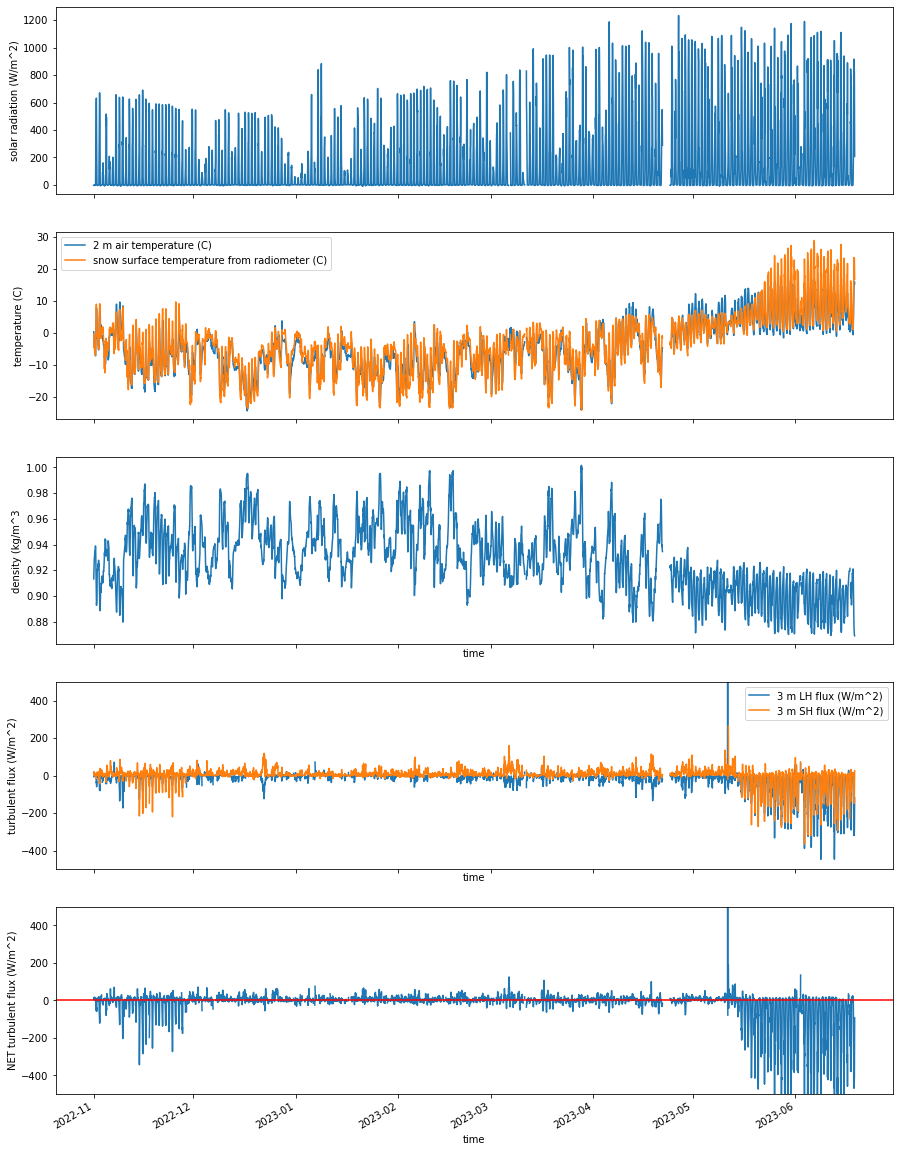

In [36]:
Lh_sub = 2835
# above we define latent heat of sublimation in J/g

cpair = 1005.7
# above is specific heat at constant pressure for dry air in J/kg/K as reported by the Glossary of Meteorology
# density of air was calculated above

# Let's make some simpler plots for the same time period to help us with interpretation.
fig, axes = plt.subplots(5,1, figsize=(15,20), sharex=True)

# I like to plot shortwave radiation to understand the timing of sunrise and relative cloudiness
# sos_dataset_60min['Rsw_in_9m_d'].plot(ax=axes[0], label='downward shortwave')
# plotting the uw sensor because it didn't break in the spring
sos_dataset_60min['Rsw_in_uw'].plot(ax=axes[0], label='downward shortwave')

# then, I like to see the actual temperatures, before the gradient is calculated
sos_dataset_60min['T_2m_c'].plot(ax=axes[1], label='2 m air temperature (C)')
# sos_dataset_60min['Tsurf_rad_d'].plot(ax=axes[1], label='snow surface temperature from radiometer (C)')
sos_dataset_60min['Tsurf_rad_uw'].plot(ax=axes[1], label='snow surface temperature from radiometer (C)')

# and check that denisty is okay
sos_dataset_60min['ro'].plot(ax=axes[2], label='2 m air temperature (C)')

# and the turbulent fluxes, converted to W/m^2 affecting the snowpack
(-Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[3], label='3 m LH flux (W/m^2)')
(-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c']).plot(ax=axes[3], label='3 m SH flux (W/m^2)')

# and the turbulent fluxes, converted to W/m^2 affecting the snowpack
(-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[4], label='sum turbulent flux (W/m^2)')

plt.axhline(y = 0, color = 'r', linestyle = '-')


axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].legend()
axes[3].legend()
axes[0].set_ylabel("solar radiation (W/m^2)")
axes[1].set_ylabel("temperature (C)")
axes[2].set_ylabel("density (kg/m^3")
axes[3].set_ylabel("turbulent flux (W/m^2)")
axes[4].set_ylabel("NET turbulent flux (W/m^2)")
axes[3].set_ylim(-500, 500)
axes[4].set_ylim(-500, 500)

plt.show()

You can see that in terms of heating or cooling the snowpack, the sensible and latent heat fluxes tend to cancel each other out, but overall, it looks like the cooling effect dominates. (Maybe sublimation saves snow?) Now, below, let's see how the turbulent fluxes and radiative fluxes compare, as well as their impact on the snow surface temperature and or melt.

(-500.0, 500.0)

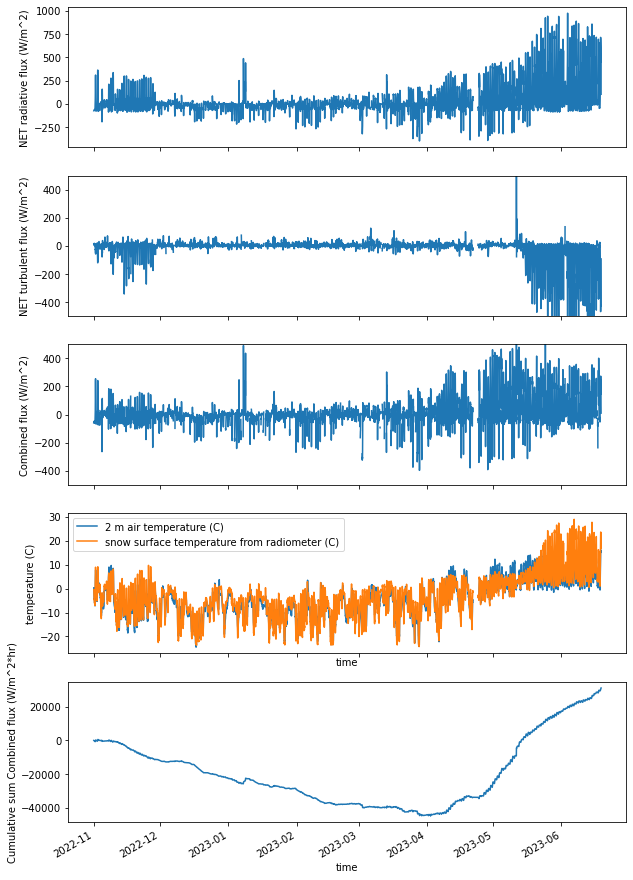

In [39]:
fig, axes = plt.subplots(5,1, figsize=(10,15), sharex=True)
# note that I'm using the uw radiometer for all of these
(sos_dataset_60min['Rsw_in_uw'] + sos_dataset_60min['LWin_uw'] - sos_dataset_60min['Rsw_out_uw'] - sos_dataset_60min['LWout_uw']).plot(ax=axes[0], label='net rad')
# and the turbulent fluxes, converted to W/m^2 affecting the snowpack
(-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[1], label='sum turbulent flux (W/m^2)')

#and add them all together
(sos_dataset_60min['Rsw_in_uw'] + sos_dataset_60min['LWin_uw'] - sos_dataset_60min['Rsw_out_uw'] - sos_dataset_60min['LWout_uw']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']).plot(ax=axes[2], label='net energy')

#plt.axhline(y = 0, color = 'r', linestyle = '-')

# and compare with surface temperature
# then, I like to see the actual temperatures, before the gradient is calculated
sos_dataset_60min['T_2m_c'].plot(ax=axes[3], label='2 m air temperature (C)')
sos_dataset_60min['Tsurf_rad_uw'].plot(ax=axes[3], label='snow surface temperature from radiometer (C)')

#and look at the cumulative energy sum
(np.cumsum(sos_dataset_60min['Rsw_in_uw'] + sos_dataset_60min['LWin_uw'] - sos_dataset_60min['Rsw_out_uw'] - sos_dataset_60min['LWout_uw']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c'])).plot(ax=axes[4], label='net energy')



axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
#axes[1].legend()
axes[3].legend()
axes[0].set_ylabel("NET radiative flux (W/m^2)")
axes[1].set_ylabel("NET turbulent flux (W/m^2)")
axes[2].set_ylabel("Combined flux (W/m^2)")
axes[3].set_ylabel("temperature (C)")
axes[4].set_ylabel("Cumulative sum Combined flux (W/m^2*hr)")
axes[1].set_ylim(-500, 500)
axes[2].set_ylim(-500, 500)

Text(0, 0.5, 'Snow pillow,\nSnow Water Equivalent [mm]')

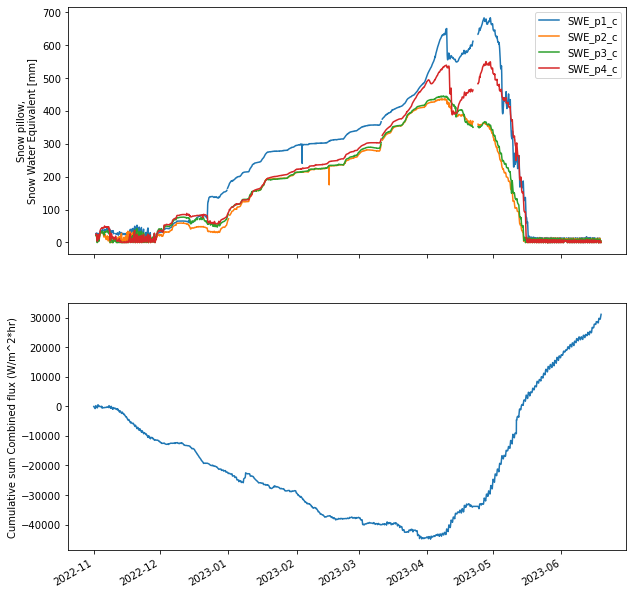

In [41]:
# And now, plot just SWE and the cumulative energy.
fig, axes = plt.subplots(2, 1, figsize=(10,10), sharex=True)
sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_60min['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')

#and look at the cumulative energy sum
(np.cumsum(sos_dataset_60min['Rsw_in_uw'] + sos_dataset_60min['LWin_uw'] - sos_dataset_60min['Rsw_out_uw'] - sos_dataset_60min['LWout_uw']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c'])).plot(ax=axes[1], label='net energy')



axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].set_ylabel("Cumulative sum Combined flux (W/m^2*hr)")
axes[0].set_ylabel("Snow pillow,\nSnow Water Equivalent [mm]")


Text(0, 0.5, 'Snow pillow,\nSnow Water Equivalent [mm]')

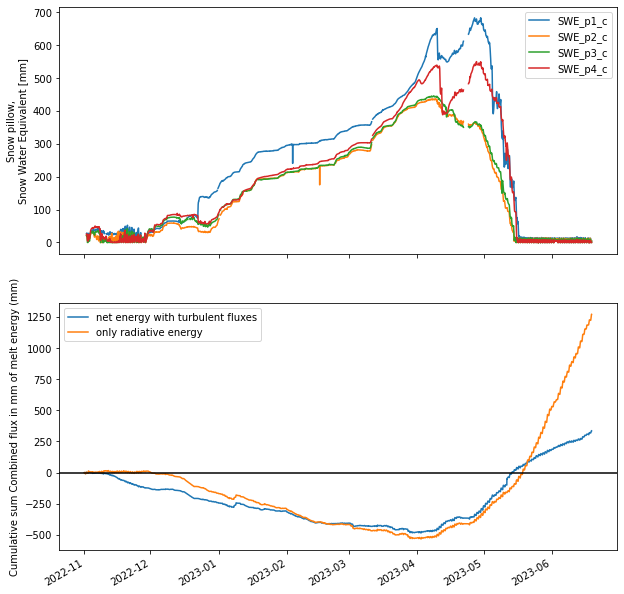

In [50]:
# and now, just to be facetious, let's say that turbulence does not matter at all, what do we get?
# And now, plot just SWE and the cumulative energy.
fig, axes = plt.subplots(2, 1, figsize=(10,10), sharex=True)
sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_60min['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')

#and look at the cumulative energy sum
# and we're going to conver the units to mm of melt energy 
# for that you multiple W/m^2*hr by 3.6/334 (using 334 J/g and 1 cm3 of water is 1 g and 3600 seconds per hr)
(np.cumsum((3.6/334)*(sos_dataset_60min['Rsw_in_uw'] + sos_dataset_60min['LWin_uw'] - sos_dataset_60min['Rsw_out_uw'] - sos_dataset_60min['LWout_uw']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c']))).plot(ax=axes[1], label='net energy with turbulent fluxes')
(np.cumsum((3.6/334)*(sos_dataset_60min['Rsw_in_uw'] + sos_dataset_60min['LWin_uw'] - sos_dataset_60min['Rsw_out_uw'] - sos_dataset_60min['LWout_uw']))).plot(ax=axes[1], label='only radiative energy')
plt.axhline(y = 0, color = 'k', linestyle = '-')

axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].set_ylabel("Cumulative sum Combined flux in mm of melt energy (mm)")
axes[0].set_ylabel("Snow pillow,\nSnow Water Equivalent [mm]")

(0.0, 400.0)

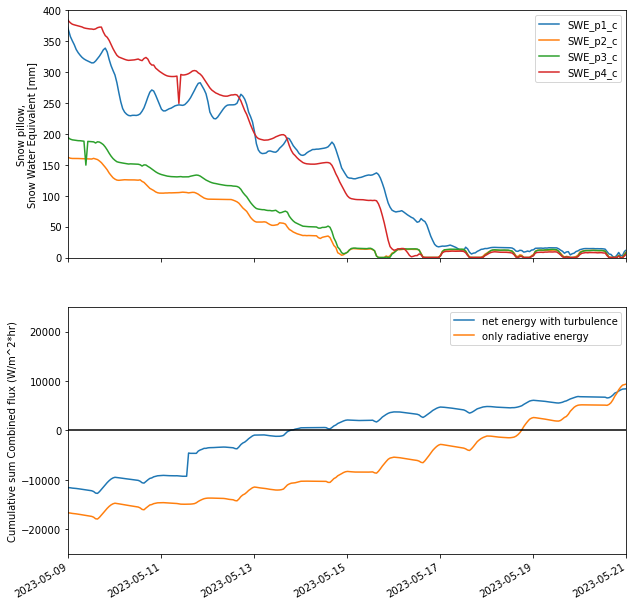

In [49]:
# and now, just to be facetious, let's say that turbulence does not matter at all, what do we get?
# And now, plot just SWE and the cumulative energy.
fig, axes = plt.subplots(2, 1, figsize=(10,10), sharex=True)
sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_60min['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')

#and look at the cumulative energy sum
(np.cumsum(sos_dataset_60min['Rsw_in_uw'] + sos_dataset_60min['LWin_uw'] - sos_dataset_60min['Rsw_out_uw'] - sos_dataset_60min['LWout_uw']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c'])).plot(ax=axes[1], label='net energy with turbulence')
(np.cumsum(sos_dataset_60min['Rsw_in_uw'] + sos_dataset_60min['LWin_uw'] - sos_dataset_60min['Rsw_out_uw'] - sos_dataset_60min['LWout_uw'])).plot(ax=axes[1], label='only radiative energy')
plt.axhline(y = 0, color = 'k', linestyle = '-')

axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].set_ylabel("Cumulative sum Combined flux (W/m^2*hr)")
axes[0].set_ylabel("Snow pillow,\nSnow Water Equivalent [mm]")
axes[0].set_xlim(dt.datetime(2023,5,9), dt.datetime(2023,5,21))
axes[1].set_xlim(dt.datetime(2023,5,9), dt.datetime(2023,5,21))
axes[1].set_ylim(-25000, 25000)
axes[0].set_ylim(0, 400)

### And now, we combine that energy sum (fix the units, with our snow temps and SWE changes -- do we predict melt?)

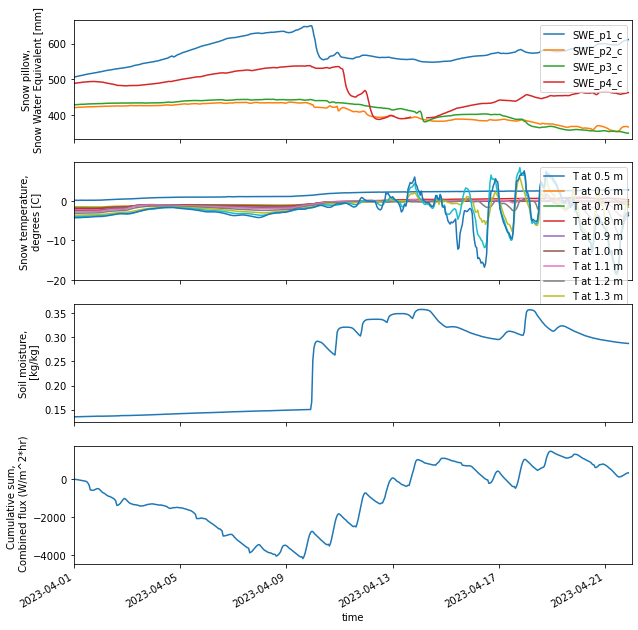

In [63]:
fig, axes = plt.subplots(4, 1, figsize=(10,10), sharex=True)
sos_dataset_60min['SWE_p1_c'].plot(ax=axes[0], label='SWE_p1_c')
sos_dataset_60min['SWE_p2_c'].plot(ax=axes[0], label='SWE_p2_c')
sos_dataset_60min['SWE_p3_c'].plot(ax=axes[0], label='SWE_p3_c')
sos_dataset_60min['SWE_p4_c'].plot(ax=axes[0], label='SWE_p4_c')

#sos_dataset_60min['Tsnow_0_4m_d'].plot(ax=axes[1], label='T at 0.4 m')
sos_dataset_60min['Tsnow_0_5m_d'].plot(ax=axes[1], label='T at 0.5 m')
sos_dataset_60min['Tsnow_0_6m_d'].plot(ax=axes[1], label='T at 0.6 m')
sos_dataset_60min['Tsnow_0_7m_d'].plot(ax=axes[1], label='T at 0.7 m')
sos_dataset_60min['Tsnow_0_8m_d'].plot(ax=axes[1], label='T at 0.8 m')
sos_dataset_60min['Tsnow_0_9m_d'].plot(ax=axes[1], label='T at 0.9 m')
sos_dataset_60min['Tsnow_1_0m_d'].plot(ax=axes[1], label='T at 1.0 m')
sos_dataset_60min['Tsnow_1_1m_d'].plot(ax=axes[1], label='T at 1.1 m')
sos_dataset_60min['Tsnow_1_2m_d'].plot(ax=axes[1], label='T at 1.2 m')
sos_dataset_60min['Tsnow_1_3m_d'].plot(ax=axes[1], label='T at 1.3 m')
sos_dataset_60min['Tsnow_1_4m_d'].plot(ax=axes[1], label='T at 1.4 m')
sos_dataset_60min['Tsnow_1_5m_d'].plot(ax=axes[1], label='T at 1.5 m')

# soil moisture
sos_dataset_60min['Qsoil_d'].plot(ax=axes[2], label='soil moisture')

#and look at the cumulative energy sum
(np.cumsum(sos_dataset_60min['Rsw_in_9m_d'] + sos_dataset_60min['LWin'] - sos_dataset_60min['Rsw_out_9m_d'] - sos_dataset_60min['LWout']-cpair * sos_dataset_60min['ro'] * sos_dataset_60min['w_tc__3m_c'] - Lh_sub * sos_dataset_60min['w_h2o__3m_c'])).plot(ax=axes[3], label='net energy')

axes[0].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[1].legend()
#axes[2].legend()
axes[0].set_ylabel("Snow pillow,\nSnow Water Equivalent [mm]")
axes[1].set_ylabel("Snow temperature,\ndegrees [C]")
axes[2].set_ylabel("Soil moisture,\n [kg/kg]")
axes[3].set_ylabel("Cumulative sum, \n Combined flux (W/m^2*hr)")
axes[0].set_xlim(dt.datetime(2023,4,1), dt.datetime(2023,4,22))
plt.show()

### Physics works!
April 10th is our magic day when we switch from net energy loss at the surface each day to net energy gain at the surface.  This is primarily due to radiation and in particular, the change in albedo, and not so much to turbulent fluxes.  And so, dust on snow appears to be more important than sublimation in stealing Colorado's snowpack...  But stay tuned, I'm sure sublimation is important for something... 

Look back at the end of lab 7-1 and calculate the total water lost to sublimation of this time period?  Any more water lost to the sky?  

In [4]:
#let's check Ethan's lidar snow depth over the whole period
lidar_depth1=xr.open_dataset("lidar_l1_pillow_depths.nc")

In [5]:
lidar_depth1

<xarray.Dataset>
Dimensions:    (time: 108, stat: 6, pillow: 2)
Coordinates:
  * time       (time) datetime64[ns] 2022-10-13 2022-10-14 ... 2023-04-17
  * stat       (stat) object 'mean' 'stddev' 'median' 'min' 'max' 'count'
  * pillow     (pillow) object 'C' 'UW'
Data variables:
    snowdepth  (time, stat, pillow) float64 ...

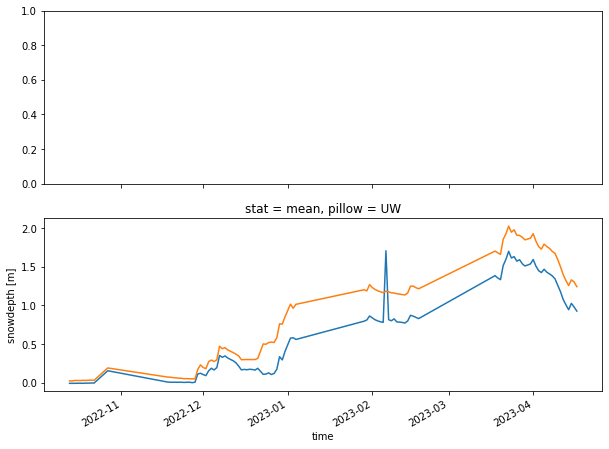

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10,7), sharex=True)
lidar_depth1['snowdepth'].sel(stat="mean",pillow="C").plot(ax=axes[1])
lidar_depth1['snowdepth'].sel(stat="mean",pillow="UW").plot(ax=axes[1])
#ds6["snowdepth"].sel(stat=s,pillow="C").plot(ax=axes[1],marker='x', linestyle="", label="c")